In [181]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

data = pd.read_csv("XBTUSD.csv")
data.head()

,timestamp,open,high,low,close,volume
0,2022-12-30 09:00:00+00:00,16462.0,16494.5,16445.5,16494.0,5892400
1,2022-12-30 08:00:00+00:00,16539.0,16539.0,16424.0,16462.0,19083200
2,2022-12-30 07:00:00+00:00,16540.5,16562.0,16523.0,16539.0,5373000
3,2022-12-30 06:00:00+00:00,16596.5,16596.5,16505.5,16540.5,11444700
4,2022-12-30 05:00:00+00:00,16587.5,16596.5,16580.0,16596.5,2362600


In [182]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 1000
Train data length : 700
Validation data lenth : 300


In [183]:
train_data = data[:length_train].iloc[:,:2] 
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])  # converting to date time object
train_data

,timestamp,open
0,2022-12-30 09:00:00+00:00,16462.0
1,2022-12-30 08:00:00+00:00,16539.0
2,2022-12-30 07:00:00+00:00,16540.5
3,2022-12-30 06:00:00+00:00,16596.5
4,2022-12-30 05:00:00+00:00,16587.5
...,...,...
695,2022-12-01 10:00:00+00:00,17111.5
696,2022-12-01 09:00:00+00:00,17068.0
697,2022-12-01 08:00:00+00:00,17124.5
698,2022-12-01 07:00:00+00:00,17106.0


In [184]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['timestamp'] = pd.to_datetime(validation_data['timestamp'])  # converting to date time object
validation_data

,timestamp,open
700,2022-12-01 05:00:00+00:00,17141.5
701,2022-12-01 04:00:00+00:00,17124.0
702,2022-12-01 03:00:00+00:00,17109.0
703,2022-12-01 02:00:00+00:00,17154.0
704,2022-12-01 01:00:00+00:00,17160.0
...,...,...
995,2022-11-18 22:00:00+00:00,16629.0
996,2022-11-18 21:00:00+00:00,16645.0
997,2022-11-18 20:00:00+00:00,16556.0
998,2022-11-18 19:00:00+00:00,16580.0


In [185]:
dataset_train = train_data.open.values
dataset_train.shape

(700,)

In [186]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(700, 1)

In [187]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(700, 1)

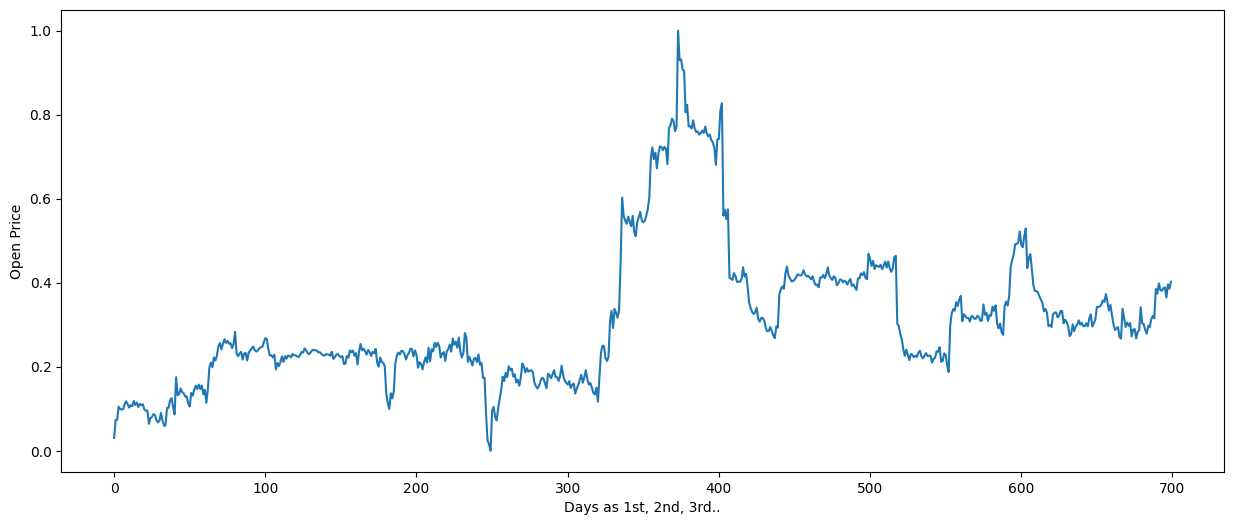

In [188]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

In [189]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [190]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (650, 50)
Shape of y_train before reshape : (650,)


In [191]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (650, 50, 1)
Shape of y_train after reshape : (650, 1)


In [192]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
21/21 [==============================] - 4s 31ms/step - loss: 0.4996 - accuracy: 0.0031
Epoch 2/50
21/21 [==============================] - 1s 25ms/step - loss: 0.3340 - accuracy: 0.0015
Epoch 3/50
21/21 [==============================] - 1s 26ms/step - loss: 0.2740 - accuracy: 0.0031
Epoch 4/50
21/21 [==============================] - 0s 24ms/step - loss: 0.2260 - accuracy: 0.0015
Epoch 5/50
21/21 [==============================] - 1s 24ms/step - loss: 0.1834 - accuracy: 0.0031
Epoch 6/50
21/21 [==============================] - 0s 23ms/step - loss: 0.1293 - accuracy: 0.0031
Epoch 7/50
21/21 [==============================] - 0s 23ms/step - loss: 0.1230 - accuracy: 0.0000e+00
Epoch 8/50
21/21 [==============================] - 1s 25ms/step - loss: 0.1097 - accuracy: 0.0015
Epoch 9/50
21/21 [==============================] - 1s 24ms/step - loss: 0.0980 - accuracy: 0.0015
Epoch 10/50
21/21 [==============================] - 1s 24ms/step - loss: 0.1048 - accuracy: 0.0031
Epoch

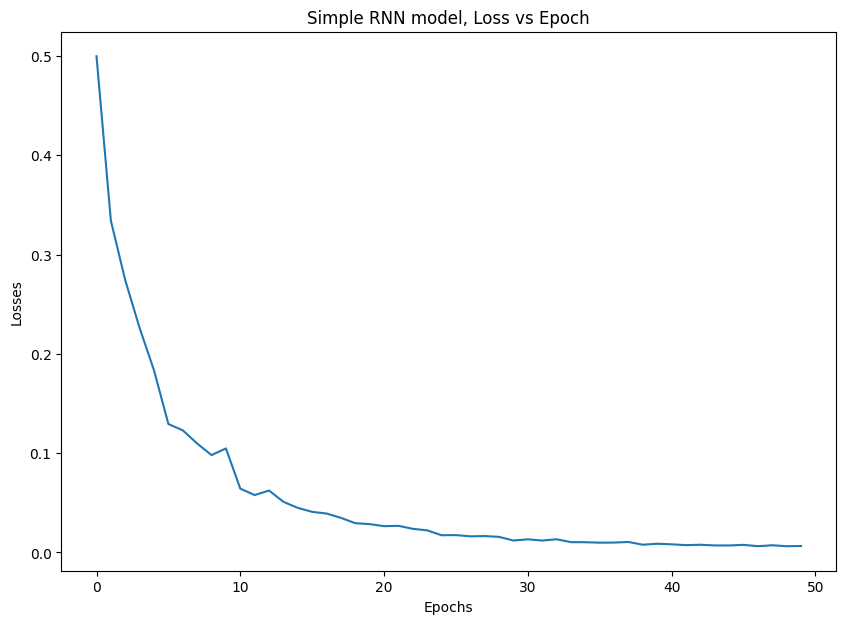

In [193]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

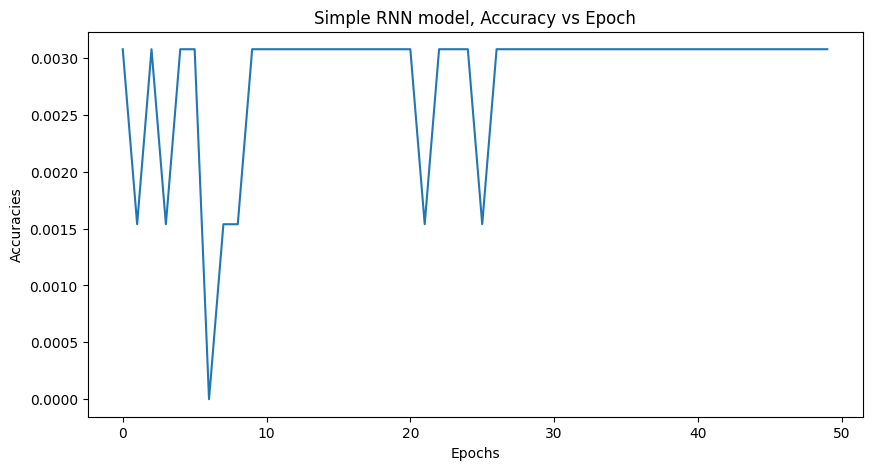

In [194]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

In [195]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

21/21 [==============================] - 1s 11ms/step


(650, 1)

In [196]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(650, 1)

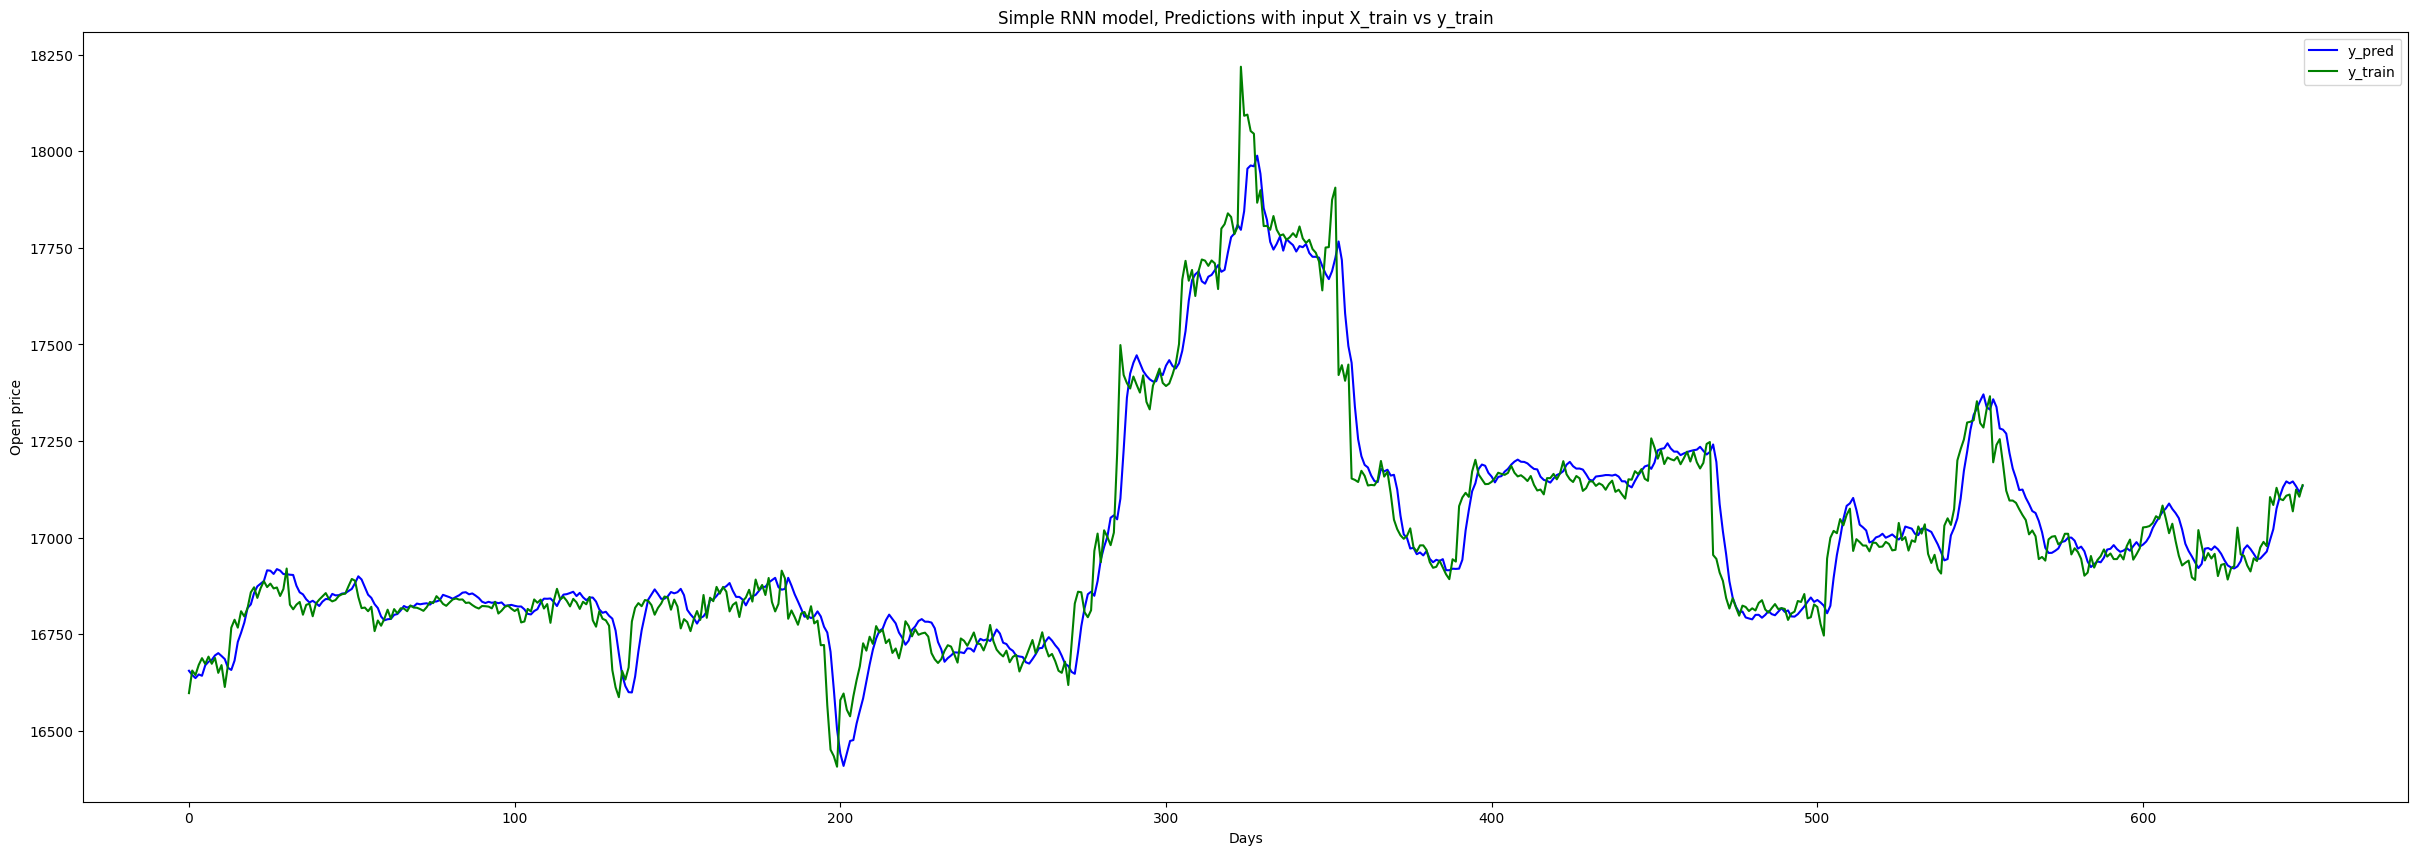

In [197]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [198]:
dataset_validation = validation_data.open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (300, 1)


In [199]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

In [200]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [201]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test before reshape : (250, 50)
Shape of y_test before reshape : (250,)
Shape of X_test after reshape : (250, 50, 1)
Shape of y_test after reshape : (250, 1)


In [202]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

8/8 [==============================] - 0s 10ms/step
Shape of y_pred_of_test : (250, 1)


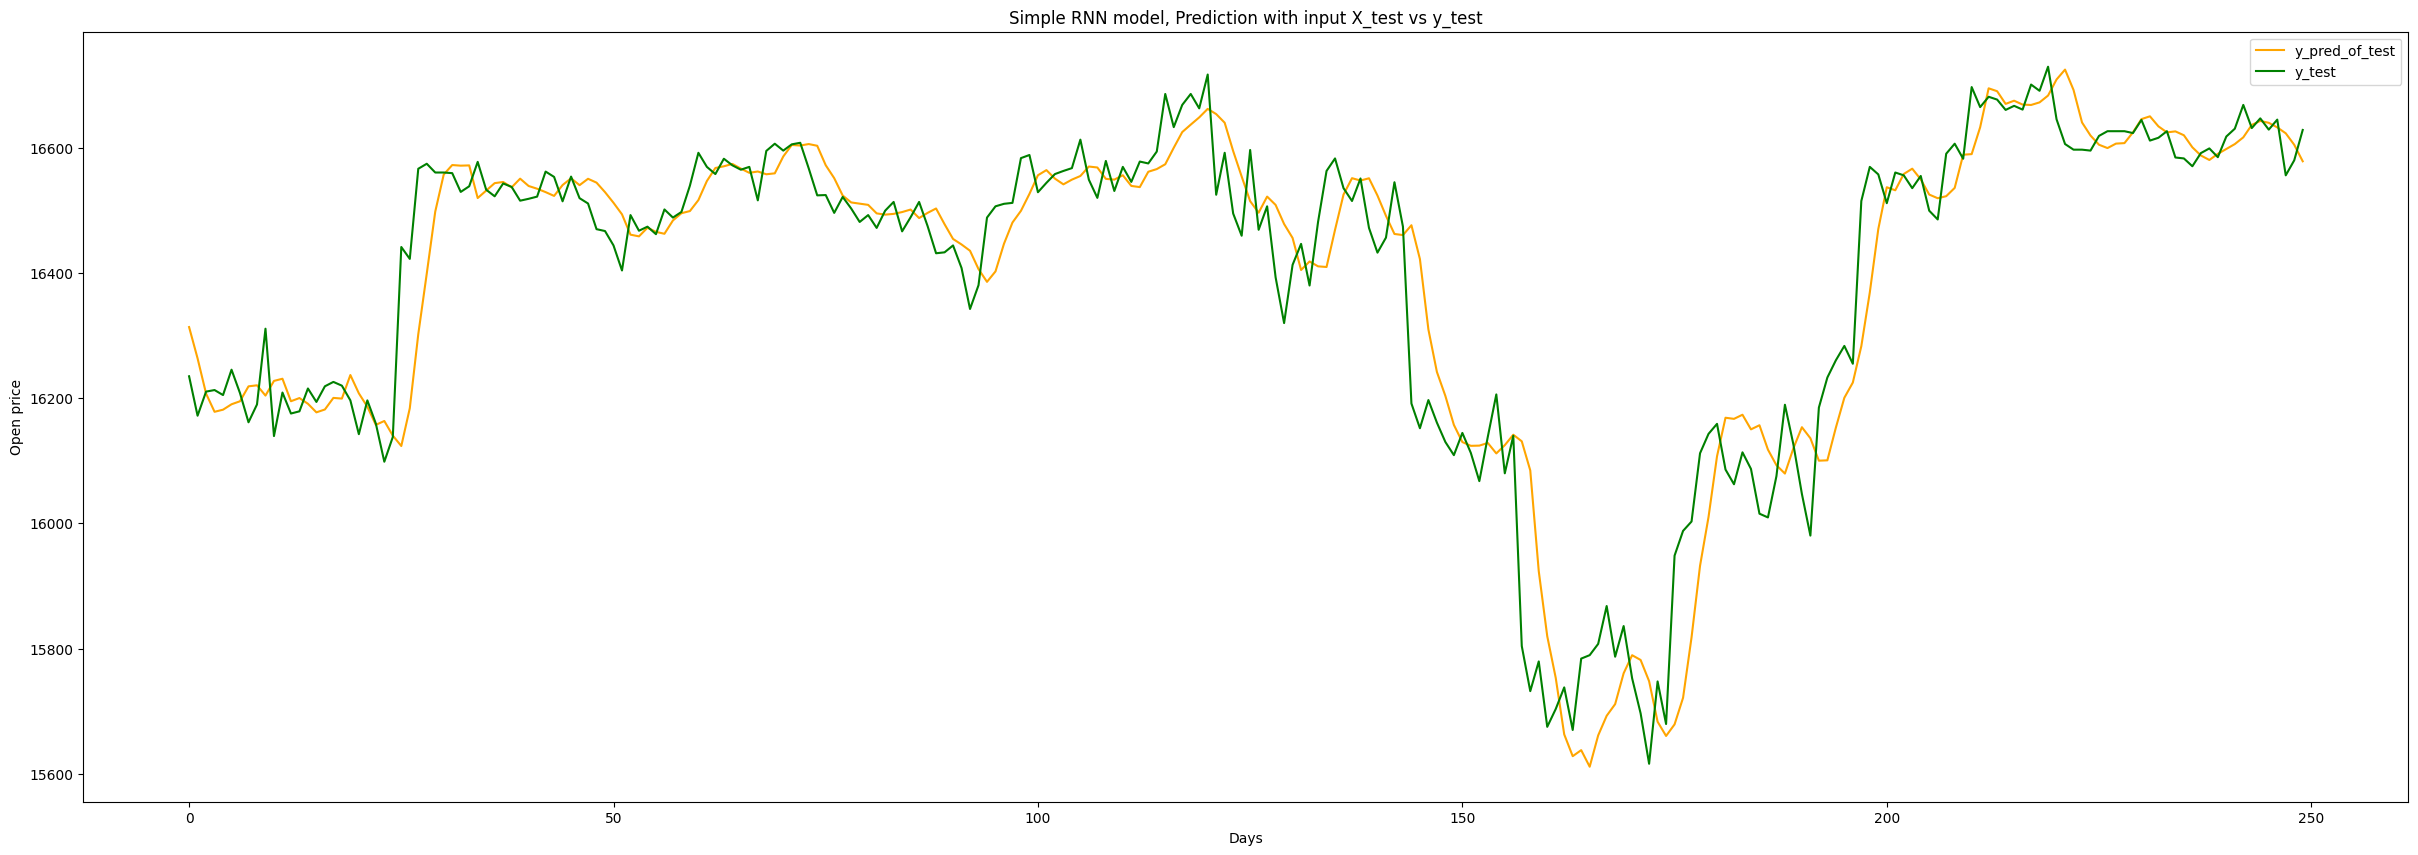

In [203]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

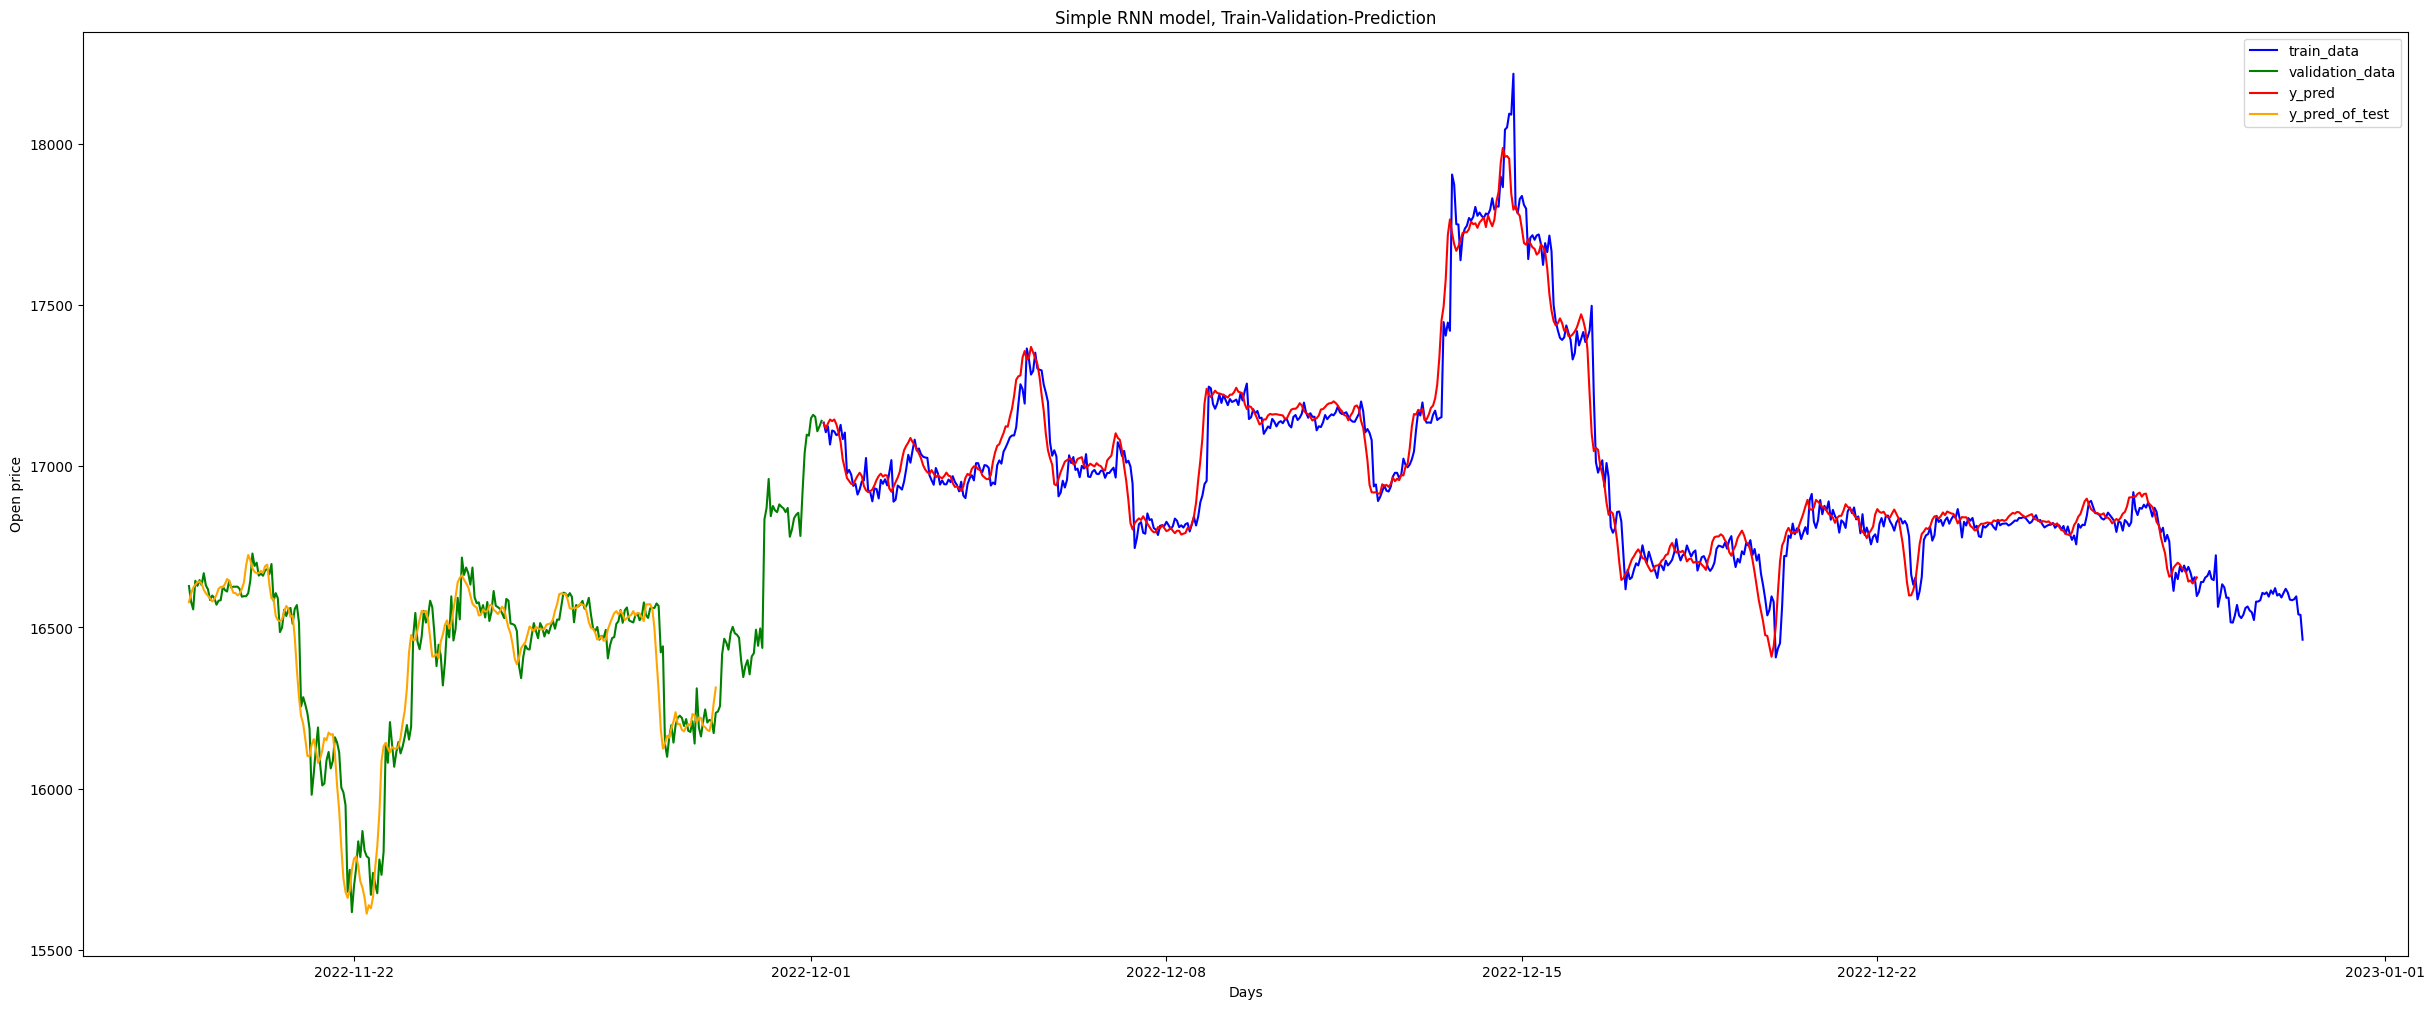

In [204]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.timestamp, train_data.open, label = "train_data", color = "b")
plt.plot(validation_data.timestamp, validation_data.open, label = "validation_data", color = "g")
plt.plot(train_data.timestamp.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.timestamp.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()